# Libraries and constants

In [2]:
library(ggplot2)
library(glue)
library(tidyverse)
library(scales)
library(grid)
library(ggpubr)
library(comprehenr)
library(listarrays)
library(lubridate)


std_width  <- 12
std_height <- 7
options(repr.plot.width = std_width, repr.plot.height = std_height)

colors <- c(
    "#fd7f6f",
    "#7eb0d5",
    "#b2e061",
    "#bd7ebe",
    "#ffb55a",
    "#8bd3c7"
)

fontsize <- 22

# Functions

Here we copy the `create_lineplot()` function that we have written for *RLAB01* to easily create lineplots.

We also create a function `date_conversion()` that takes as input a time series and convert it in either week number or month number. 

In [3]:
#' create_lineplot 
#' 
#' this function creates simple ggplot with geom_line() 
#' @param data     : (data.frame or tibble) data in a dataframe or tibble structure
#' @param x        : (string) name of the column to display as x-axis 
#' @param y        : (string) name of the column to display as y-axis 
#' @param group    : (string) name of the column used to group data 
#' @param color    : (string) line color
#' @param palette  : (array)  array of colors to be used when group is not NULL
#' @param lw       : (int)    line width
#' @param fontsize : (int)    font size of axis labels - other fontsizes are automatically updated
#' @param title    : (string) plot title
#' @param xlabel   : (string) x-axis title
#' @param ylabel   : (string) y-axis title
#' @param clabel   : (string) legend title
#' @param date     : (string) week or month
#' @param scilab   : (bool)   if TRUE y-axis labels are in scientific notation
#' @param ylog     : (bool)   if TRUE y-axis is in log-scale
#' @param ylog     : (bool)   if TRUE shows log10 ticks
#' @return         : (ggplot) returns the ggplot object
create_lineplot <- function(
    data,
    x,
    y,
    group      = NULL,
    color      = "#DC3522",
    palette    = NULL,
    lw         = 2,
    fontsize   = 22,
    title      = "plot",
    xlabel     = "x",
    ylabel     = "y",
    clabel     = NULL,
    date       = "week",
    scilab     = FALSE,
    ylog       = FALSE,
    ylog_ticks = FALSE
) {
    # create the ggplot object
    plt <- ggplot(data = data, aes_string(x = x, y = y, color = group)) +
    # add line
    {if(!is.null(color)) ggplot2::geom_line(color = color, size = lw)} +
    {if(is.null(color))  ggplot2::geom_line(size = lw)} +
    theme_classic() +
    # adjust font sizes and grid
    theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize - 4),
    axis.text.x  = element_text(angle = 30, hjust = 1),
    panel.grid.major.y = element_line(
        color    = alpha("black", 0.2),
        size     = 0.5,
        linetype = 1
        )
    ) +
    {if (scilab) scales::scale_y_continuous(labels = scales::scientific)} +
    {if (ylog) scale_y_continuous(
            trans  = log10_trans(),
            breaks = trans_breaks("log10", function(x) 10^x),
            labels = trans_format("log10", math_format(10^.x))
        )
    } +
    {if (ylog_ticks) ggplot2::annotation_logticks(sides = "l")} +
    # set title and labels
    labs(
        title = title,
        x     = xlabel,
        y     = ylabel,
        color = clabel,
    ) +
    scale_color_manual(values = palette) +
    scale_x_date(date_breaks = "2 month")

    return(plt)
}

# this function converts a date into a its week number or month number
date_conversion <- function(date_type, date) {
    if (date_type == "week") {
        lubridate::week(date)
    }
    else if (date_type == "month") {
        lubridate::month(date)
    }
    else {
        print("ERROR! Not a valid date conversion!")
    }
}

---

# Exercise 1 - Community Mobility Open Data

The following categoriesare available:

- `retail_and_recreation`, i.e. places like restaurants,cafes, shopping centers, theme parks,museums,libraries, and movie theaters
- `grocery_and_pharmacy`, i.e. grocery markets, food warehouses, farmers markets, specialtyfood shops, drug stores, and pharmacies
- `parks`, i.e. national parks, public beaches, marinas, dog parks, plazas,and public gardens
- `transitstations`, i.e. all public transport hubs such as subway, bus, and train stations
- `workplaces`, i.e. places of work
- `residential`, i.e. people’s residence

Select a couple of European countries of your choice and analyze the trends in the previousvariables over time: produce a plot of the data by averaging the observable over a period of one week (hint: convert the data field to `lubridate::week`) and one month and quantify the impact of COVID-19 restrictions on mobility sitations.

In [4]:
# DATA

folder <- "data/"
fname  <- "Global_Mobility_Report.csv"

filename <- paste(folder, fname, sep = "")

data     <- read_delim(filename, delim = ",", show_col_types = FALSE)

### Data preprocessing

In [5]:
# alpha-2 country codes we want to keep
countries <- c("IT", "DE", "FR", "UA", "ES", "PL")

# column names to drop
drop_cols <- c(
    "sub_region_1",
    "sub_region_2",
    "metro_area",
    "iso_3166_2_code",
    "census_fips_code",
    "place_id"
)

# new column names
col_names <- c(
    "country_id",
    "country",
    "date",
    "retail_and_recreation",
    "grocery_and_pharmacy",
    "parks",
    "transit_stations",
    "workplaces",
    "residential"
)

# keep only the selected countries
# keep only national data
# keep only the year 2020
data_ <- filter(
    data,
    country_region_code %in% countries &
    is.na(sub_region_1) &
    between(date, as.Date("2020-01-01"), as.Date("2020-12-31"))
)

# drop useless columns
df <- data_ %>% select(-one_of(drop_cols))

# rename columns
colnames(df) <- col_names

# add two column that represent week number and month number
df$week  <- date_conversion("week",  as.Date(df$date))
df$month <- date_conversion("month", as.Date(df$date))

# add two column that represent week number and month number as a date
df$wdate <- lubridate::ymd("2020-01-01") + lubridate::weeks(df$week - 1)
df$mdate <- lubridate::ymd(paste("2020-", df$month, "-01", sep = ""))

# change the column order
df <- df %>% relocate(week,  .after = date)
df <- df %>% relocate(month, .after = week)
df <- df %>% relocate(wdate, .after = week)
df <- df %>% relocate(mdate, .after = month)

head(df)

country_id,country,date,week,wdate,month,mdate,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
<chr>,<chr>,<date>,<dbl>,<date>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DE,Germany,2020-02-15,7,2020-02-12,2,2020-02-01,6,1,45,10,0,-1
DE,Germany,2020-02-16,7,2020-02-12,2,2020-02-01,7,10,9,6,-1,0
DE,Germany,2020-02-17,7,2020-02-12,2,2020-02-01,2,2,7,1,-2,0
DE,Germany,2020-02-18,7,2020-02-12,2,2020-02-01,2,2,10,1,-1,1
DE,Germany,2020-02-19,8,2020-02-19,2,2020-02-01,3,0,6,-1,-1,1
DE,Germany,2020-02-20,8,2020-02-19,2,2020-02-01,2,-1,14,3,-4,1


### Weekly average processing

In [6]:
# WEEKLY AVERAGE

# group by country and by week number
# compute the average of the features of interest
wdf <- aggregate(
    list(
        df$wdate,
        df$retail_and_recreation,
        df$grocery_and_pharmacy,
        df$parks,
        df$transit_stations,
        df$workplaces,
        df$residential
    ),
    by = list(df$country, df$week),
    mean
)

# change column names
colnames(wdf) <- c(
    "country",
    "week",
    "wdate",
    "retail_and_recreation_w_avg",
    "grocery_and_pharmacy_w_avg",
    "parks_w_avg",
    "transit_stations_w_avg",
    "workplaces_w_avg",
    "residential_w_avg"
)

head(wdf)

,country,week,wdate,retail_and_recreation_w_avg,grocery_and_pharmacy_w_avg,parks_w_avg,transit_stations_w_avg,workplaces_w_avg,residential_w_avg
,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,France,7,2020-02-12,2.50,1.250,21.000,2.25,-8.00,1.25
2,Germany,7,2020-02-12,4.25,3.750,17.750,4.50,-1.00,0.00
3,Italy,7,2020-02-12,2.25,0.750,21.000,6.75,0.75,-0.75
4,Poland,7,2020-02-12,7.00,-3.500,19.250,2.50,0.00,0.00
5,Spain,7,2020-02-12,0.50,0.750,13.250,5.00,1.25,-1.25
6,Ukraine,7,2020-02-12,4.25,3.125,4.625,4.75,4.00,-0.25


### Monthly average processing

In [7]:
# MONTHLY AVERAGE

# group by country and by month number
# compute the average of the features of interest
mdf <- aggregate(
    list(
        df$mdate,
        df$retail_and_recreation,
        df$grocery_and_pharmacy,
        df$parks,
        df$transit_stations,
        df$workplaces,
        df$residential
    ),
    by = list(df$country, df$month),
    mean
)

# change column names
colnames(mdf) <- c(
    "country",
    "month",
    "mdate",
    "retail_and_recreation_m_avg",
    "grocery_and_pharmacy_m_avg",
    "parks_w_avg",
    "transit_stations_m_avg",
    "workplaces_m_avg",
    "residential_m_avg"
)

head(mdf)

,country,month,mdate,retail_and_recreation_m_avg,grocery_and_pharmacy_m_avg,parks_w_avg,transit_stations_m_avg,workplaces_m_avg,residential_m_avg
,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,France,2,2020-02-01,-0.600000,0.4666667,20.066667,1.0000000,-10.4000000,2.000000
2,Germany,2,2020-02-01,1.200000,2.4000000,10.333333,0.4666667,-4.7333333,1.266667
3,Italy,2,2020-02-01,-3.000000,2.6000000,15.533333,-4.0000000,-4.5333333,1.600000
4,Poland,2,2020-02-01,3.133333,-1.8666667,7.400000,2.0666667,3.1333333,0.000000
5,Spain,2,2020-02-01,1.200000,2.0000000,20.533333,5.3333333,-0.5333333,-1.066667
6,Ukraine,2,2020-02-01,4.300000,4.2333333,8.433333,6.0000000,5.3666667,-0.900000


### Weekly average plots

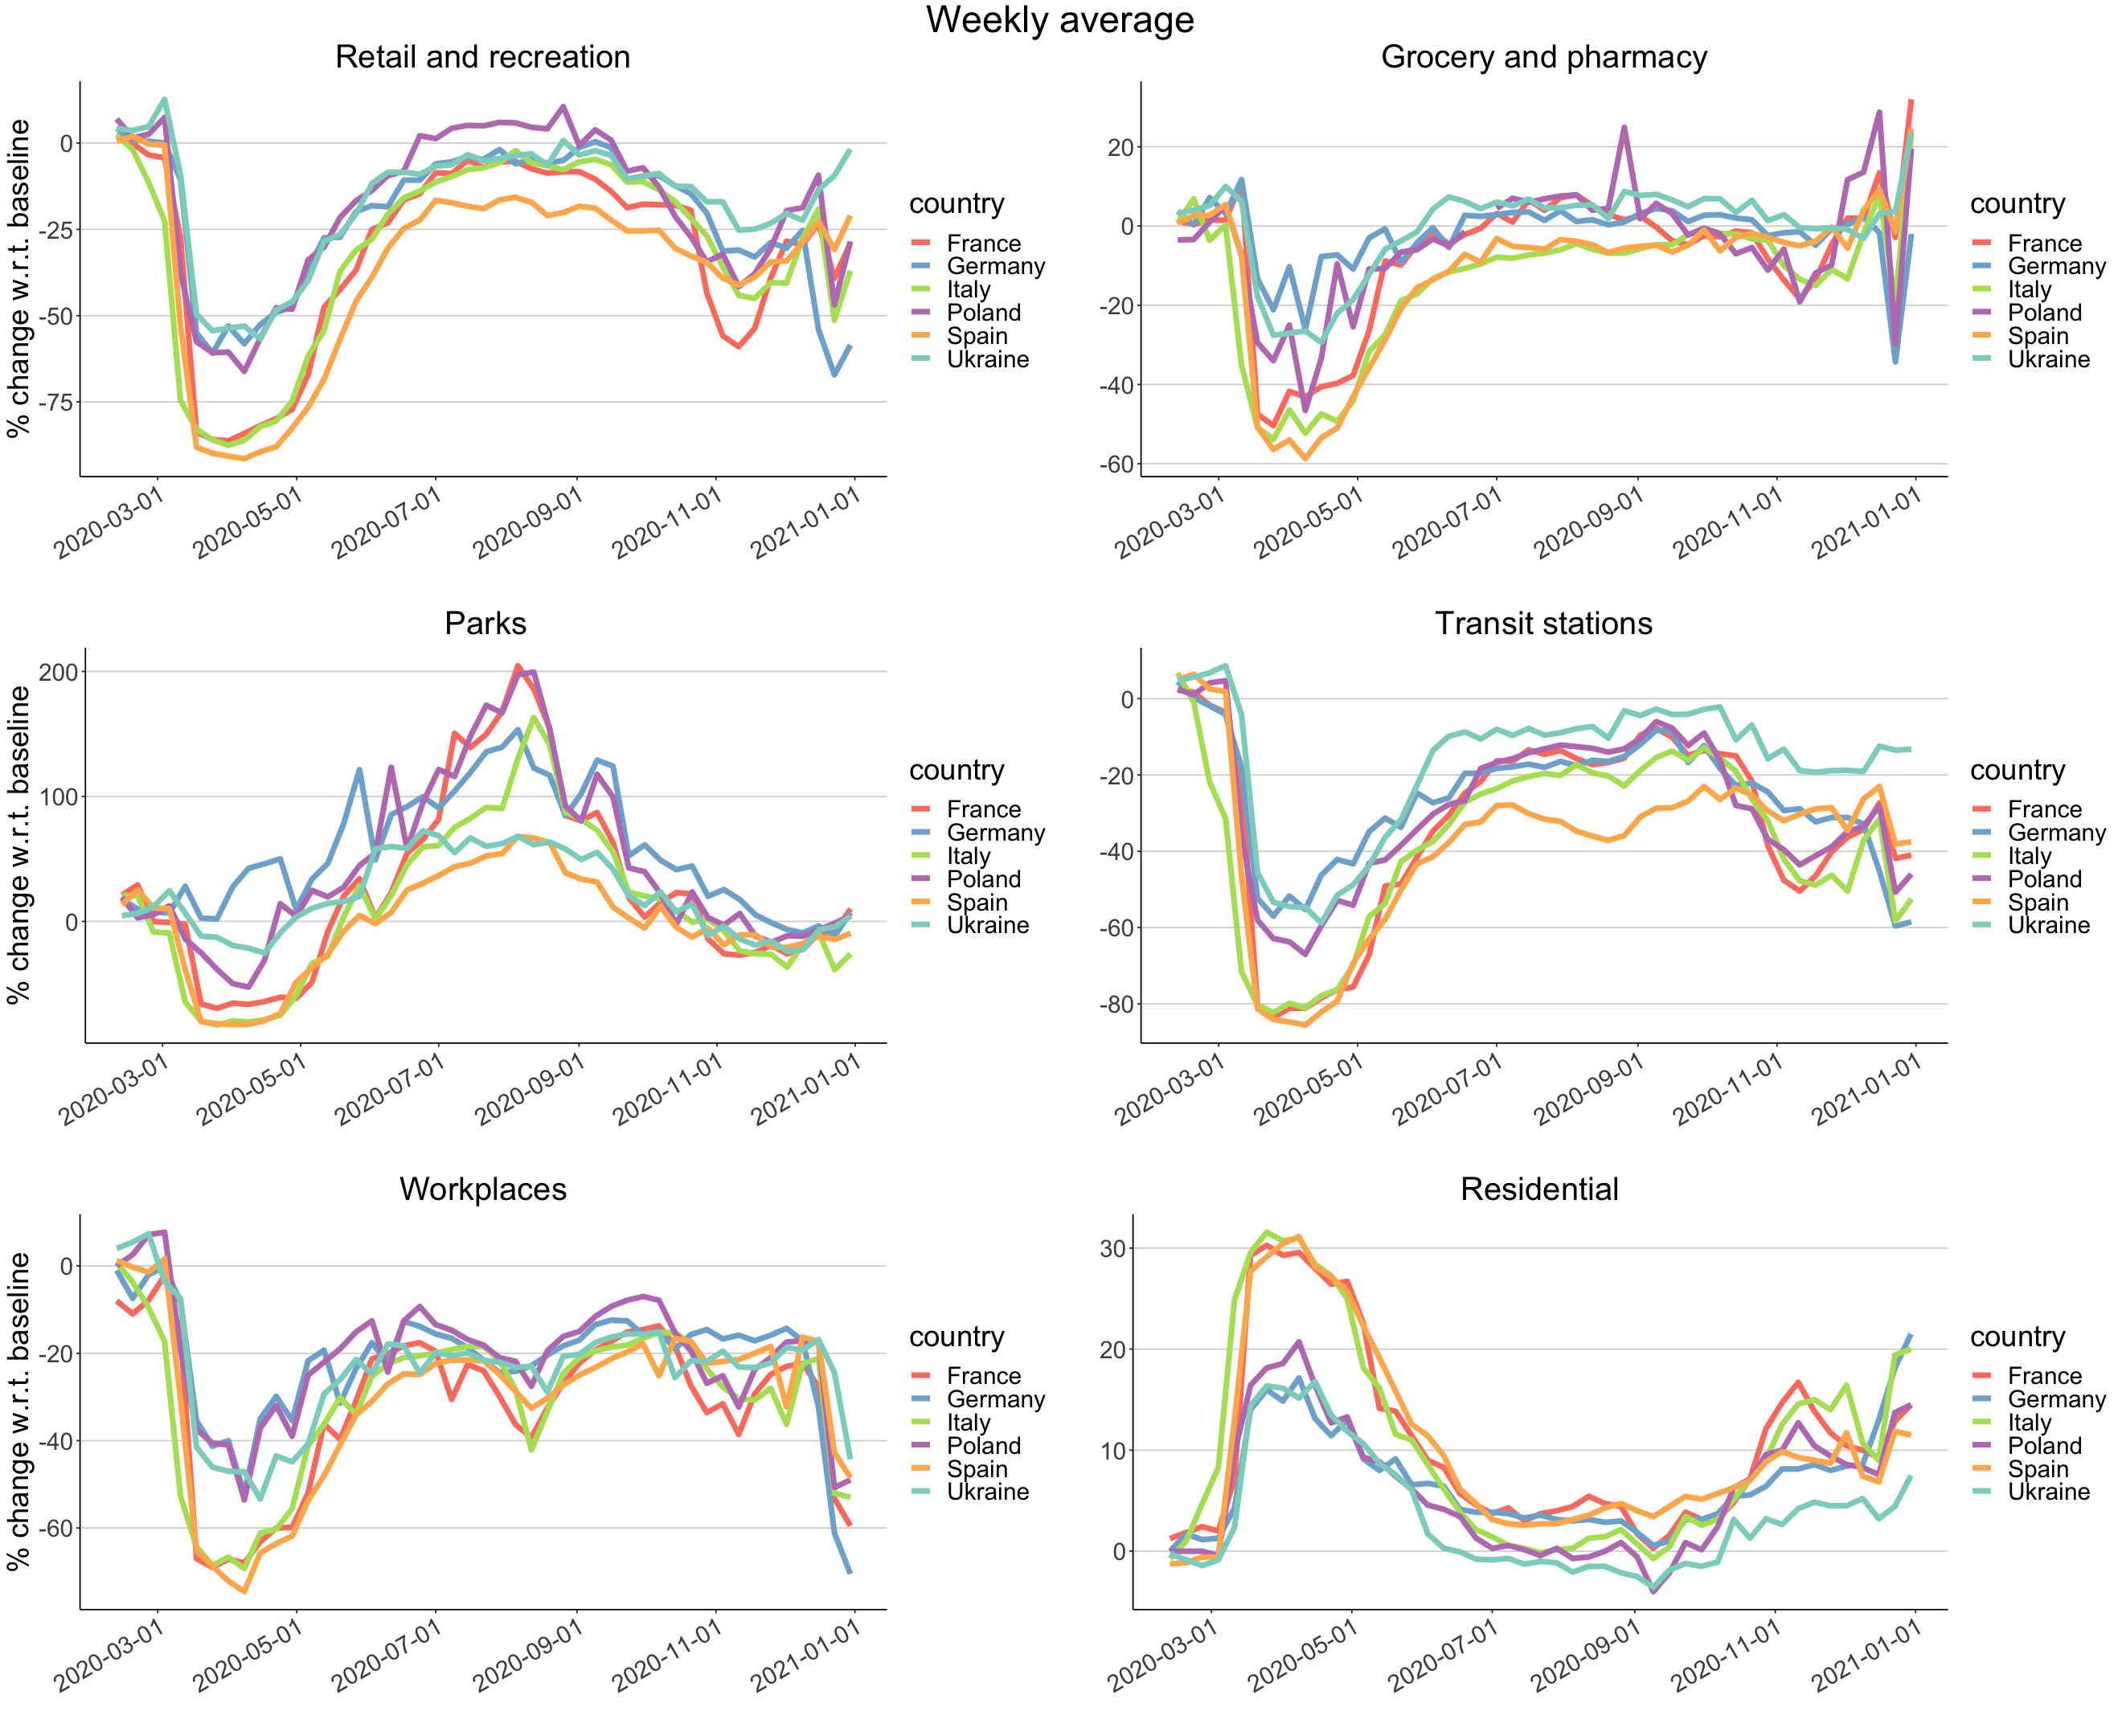

In [8]:
# empty list to hold plots
plots_w <- list()

# plot titles
titles <- c(
    "Retail and recreation",
    "Grocery and pharmacy",
    "Parks",
    "Transit stations",
    "Workplaces",
    "Residential"
)

# for each feature
for (i in 1:6) {

    if (i == 1 | i == 3 | i == 5) {
        ylab <- "% change w.r.t. baseline"
    }
    else {
        ylab <- ""
    }

    # create the plot
    plt <- create_lineplot(
        data    = wdf,
        x       = "wdate",
        y       = colnames(wdf[i + 3]),
        group   = "country",
        color   = NULL,
        palette = colors,
        title   = titles[i],
        xlabel  = "",
        ylabel  = ylab,
        clabel  = "country"
    )

    # and save it inside the list
    plots_w[[i]] <- plt
}


# figure adjustments
options(repr.plot.width = 22, repr.plot.height = 18)
plot_w <- ggarrange(plotlist = plots_w, nrow = 3, ncol = 2)
annotate_figure(
    plot_w,
    top = text_grob(
        "Weekly average",
        color = "black",
        size  = fontsize + 6
    )
)
options(repr.plot.width = std_width, repr.plot.height = std_height)

### Monthly average plots

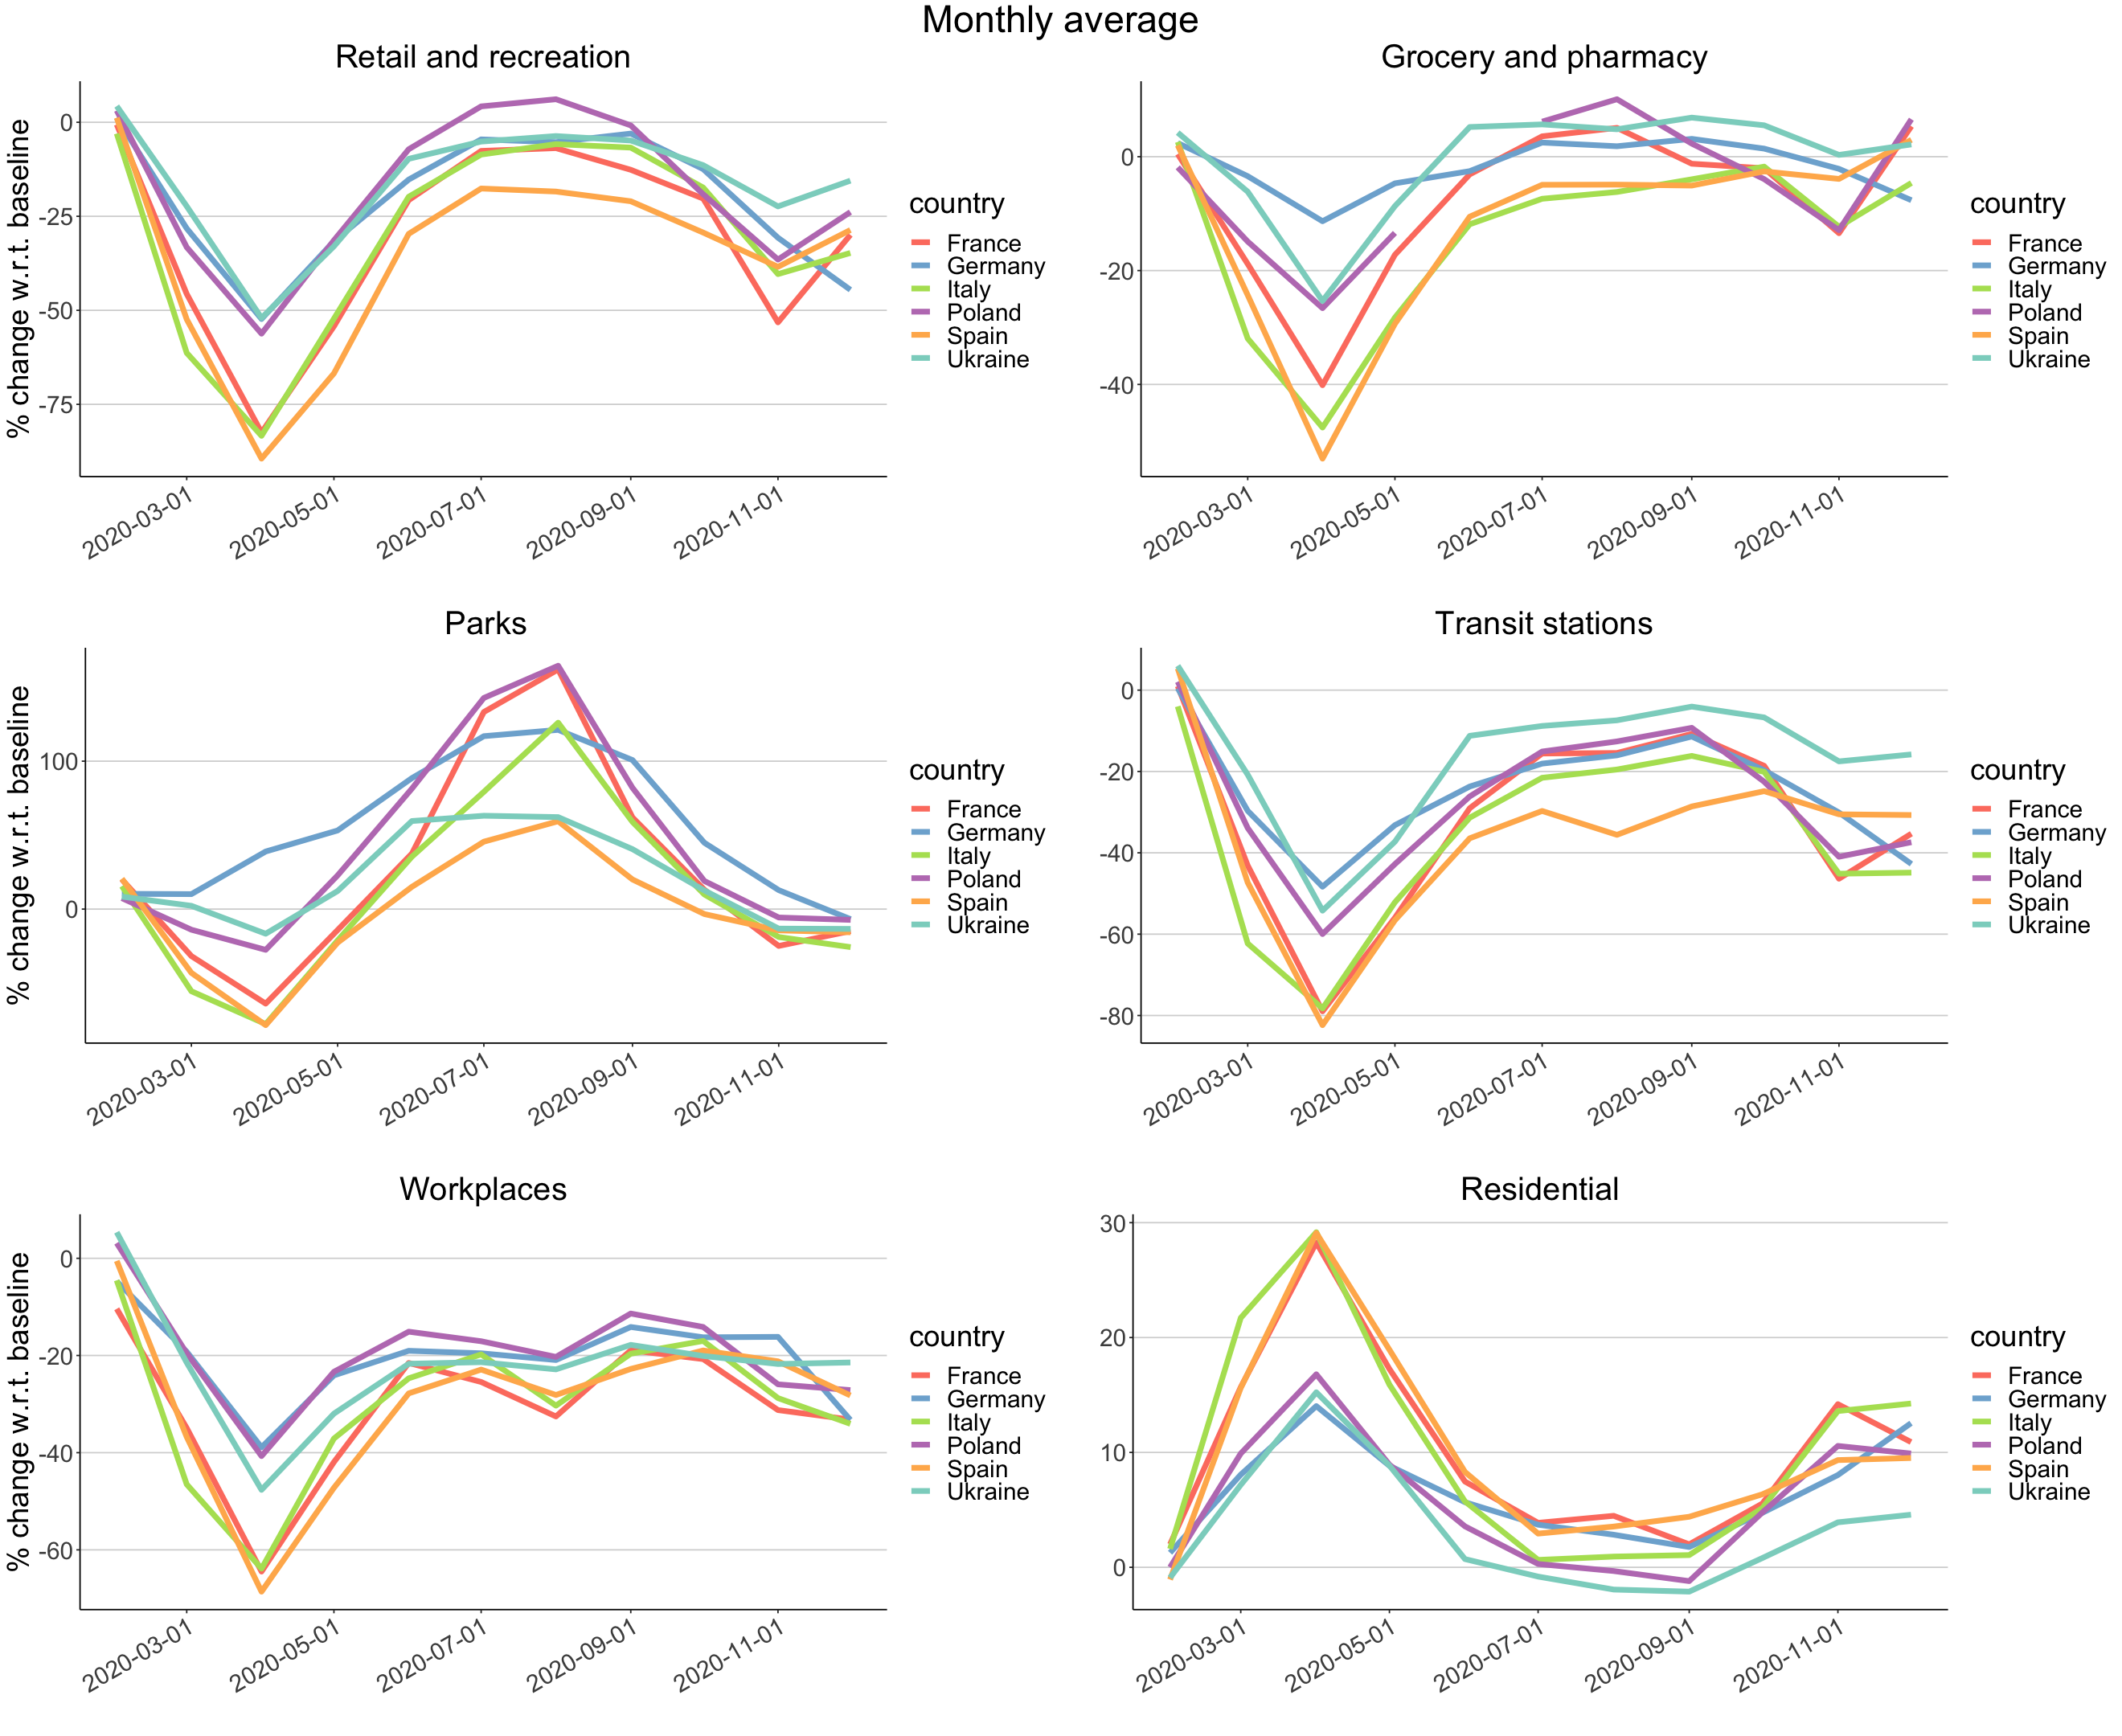

In [9]:
# empty list to hold plots
plots_m <- list()

# plot titles
titles <- c(
    "Retail and recreation",
    "Grocery and pharmacy",
    "Parks",
    "Transit stations",
    "Workplaces",
    "Residential"
)

# for each feature
for (i in 1:6) {

    if (i == 1 | i == 3 | i == 5) {
        ylab <- "% change w.r.t. baseline"
    }
    else {
        ylab <- ""
    }

    # create the plot
    plt <- create_lineplot(
        data    = mdf,
        x       = "mdate",
        y       = colnames(mdf[i + 3]),
        group   = "country",
        color   = NULL,
        palette = colors,
        title   = titles[i],
        xlabel  = "",
        ylabel  = ylab,
        clabel  = "country"
    )

    # and save it inside the list
    plots_m[[i]] <- plt
}


# figure adjustments
options(repr.plot.width = 22, repr.plot.height = 18)
plot_m <- ggarrange(plotlist = plots_m, nrow = 3, ncol = 2)
annotate_figure(
    plot_m,
    top = text_grob(
        "Monthly average",
        color = "black",
        size  = fontsize + 6
    )
)
options(repr.plot.width = std_width, repr.plot.height = std_height)

### Impact of COVID-19 on transit stations

The two plots above show that transit stations is the category, among the others that we have considered here, that suffered the most the restrictions applied to fight COVID-19 in 2020, especially in the first half of the year. 

We see a negative peak in April 2020, where some countries (Italy, France, Spain) reached -80% visitors, compared to the median of the first five weeks of 2020, in transit stations. 

In other countries (Germany, Poland, Ukraine), instead, the peak reached less dramatic values. Looking at the other categories, these countries, overall, had less dramatic values although all countries seem to follow the same trend.

Nevertheless, transit stations reached the highest negative percent change for each country we have considered.

---

# Exercise 2 - Random number generators

One of the first random number generator was proposed by von Neumann, the so-called *middle square algorithm*.

Write R code to implement this type of generator and, given a fixed digit number input, square it an remove the leading and trailing digits, in order to return a number with thesame number of digits as the original number.

In [10]:
# this function takes as input a number x
# and returns the same number as a list of characters
# where each character corresponds to its digits
list_of_ch <- function(x) {
    c <- unlist(
        strsplit(
            as.character(
                format(x, scientific = FALSE)
            ),
            ""
        )
    )
    return(c)
}

# this function takes as input a number x
# and returns the middle part of its square x^2
# where the middle part has the same number of digits
# as the original number x
remove_head_tail <- function(x) {

    x_sq <- x^2

    # from number to list of characters
    x_str    <- list_of_ch(x)
    x_sq_str <- list_of_ch(x_sq)

    # parameters for removing head and tail
    l_x    <- length(x_str)
    l_x_sq <- length(x_sq_str)
    t      <- (l_x_sq - l_x) %/% 2

    # random number from x^2
    y  <- x_sq_str[-c(1:t, (t + l_x + 1):l_x_sq)]

    return(as.numeric(paste(y, collapse = "")))
}

# this function is the implementation of von Neumann middle square algorithm
# it takes as input the number x of length k and the number of iterations n
# it return a random number y
r_middle_square <- function(x, n) {

    # compute the lenght k of the number x
    k <- length(list_of_ch(x))

    # for each iteration
    for (i in 1:n) {
        # compute the random number
        x <- remove_head_tail(x)
        if (length(list_of_ch(x)) < k) {
            x <- x * 10
        }
    }
    y <- x
    return(y)

}

r_middle_square(78932789348, 20)

[1] 82448179367

---

# Exercise 3 - Bayesian Inference (1)

A publishing company has recently launched a new journal. In order to determine how effective it is in reaching its possible audience, a market survey company selects a random sample of people from a possible target audience and interviews them. Out of 150 interviewed people, 29 have read the last issue of the journal.

A) What kind of distribution would you assume for $y$, the number of people that have seen the last issue of the journal?

B) Assuming a uniform prior, what is the posterior distribution for $y$?

C) Plot both posterior and likelihood distribution functions.

## A)

I would assume a Binomial distribution for $y$, the number of people that have seen the last issue of the journal.

If we interview one persone, we have a probability $p$ that it has read the journal. Thus, if we interview $n$ people, the number of people that read the journal follows a Binomial distribution with parameters $p$ and $n$. 

## B)

Bayes theorem tells us that 

$$
P(M|D) = \frac{P(D|M)\,P(M)}{P(D)}
$$

Assuming a Uniform distribution as our prior $P(D)$, namely $P(M) = U(0,\,1)$, we can easily compute the posterior distribution $P(M|D)$ without the need of explicitely computing the evidence $P(D)$.

Let us recall that the Uniform distribution between $a=0$ and $b=1$ can be written as a Beta function with parameters $\alpha=1$ and $\beta=1$. In other words, our prior is $P(M)=U(0,\,1)=Beta(1,\,1)$.

The Beta function is the conjugate prior of a Binomial likelihood, and thus the posterior is a conjugate distribution of the Beta prior. Namely, the posterior is another Beta function with different parameters!

If our Beta prior has parameters $\alpha_p$ and $\beta_p$, given $k$ successes in $n$ trials, the posterior is then a Beta function with parameters

$$
\begin{align}
    \alpha = \alpha_p + k \,\,\,\,&\,\,\,\,\text{and}\,\,\,\,& \beta = \beta_p + n - k
\end{align}
$$

In our specific case, given $n=150$ and $k=29$, the posterior distribution is exactly $Beta(\alpha=30,\, \beta=122)$.


## C)

Let us plot the three distributions: likelihood, prior and posterior.     

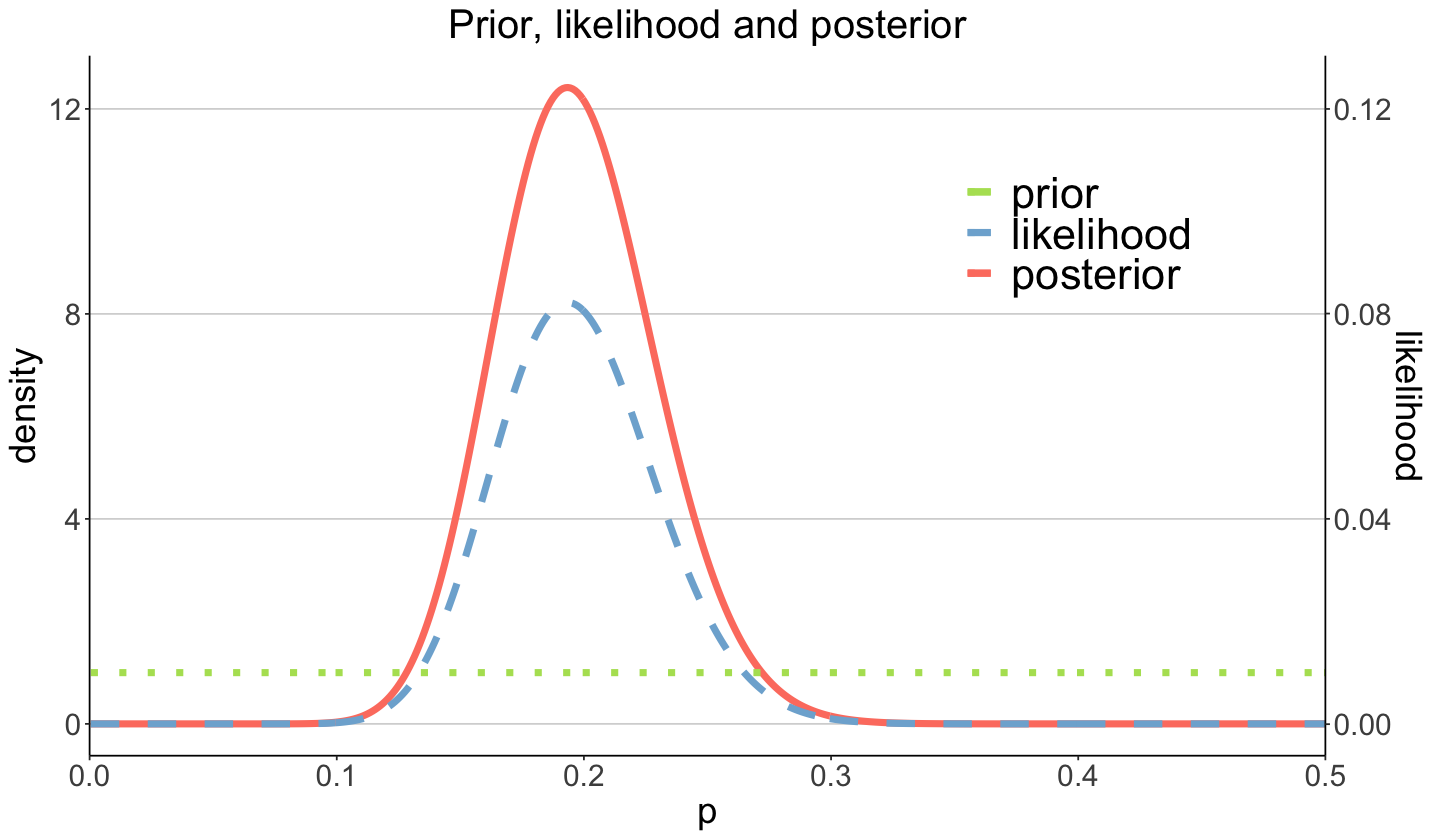

In [11]:
# binomial distribution paramters
n <- 150
k <- 29

# parameter we want to infer from data
n_grid <- 1000
p <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)

# step
delta_p <- 1 / n_grid

# uniform prior beta parameters
alpha_p <- 1
beta_p  <- 1

# posterior beta paramters
alpha <- alpha_p + k
beta  <- beta_p + n - k

# the three distribution functions
prior      <- dbeta(x = p, shape1 = alpha_p, shape2 = beta_p)
likelihood <- dbinom(x = k, size = n, prob = p)
posterior  <- dbeta(x = p, shape1 = alpha, shape2 = beta)

# PLOT
plt <- ggplot() +
geom_line(aes(x = p, y = posterior,  color = "posterior"), size = 2, linetype = "solid")  +
geom_line(aes(x = p, y = prior,      color = "prior"), size = 2, linetype = "dotted") +
geom_line(aes(x = p, y = likelihood * 100, color = "likelihood"), size = 2, linetype = "dashed") +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    legend.position = c(0.8, 0.785),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = "Prior, likelihood and posterior",
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 0.5)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
    name = "",
    values = c(colors[3], colors[2], colors[1]),
    breaks = c("prior", "likelihood", "posterior")
) +
scale_y_continuous(sec.axis = sec_axis(~. / 100, name = "likelihood"))

plt

Mind the likelihood scale on the right of the figure.

---

# Exercise 5 - Bayesian Inference (2)

A coin is flipped $n=30$ times with thw following outcomes:

T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H

A) Assuming a flat prior, and a Beta prior, plot the likelihood, prior and posterior distributions for the data set.

B) Evaluate the most probable value for the coin probability $p$ and, integrating the posterior probability distribution, give an estimate for a 95% credibility interval.

C) Repeat the same analysis assuming a sequential analysis of the data. Show how the most probable value and the credibility interval change as a function of the number of coin tosses.

D) Do you get a different result, by analyzing the data sequentially with respect to a one-step analysis (i.e. considering all the data as a whole)?

## A)

First, let us get more quantitative information about the data we have been provided. 

Since we are dealing with Bernoulli processes, we want to find parameters for a Binomial distribution.

In [12]:
H      <- "H"
T      <- "T"
tosses <- c(T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H)

n_H <- length(tosses[tosses == "H"])
n_T <- length(tosses[tosses == "T"])

k <- n_H
n <- n_H + n_T

cat(glue("In {n} coin tosses we got {k} times head and {n-k} times tail."))

In 30 coin tosses we got 15 times head and 15 times tail.

Now, we have found two out of the three parameters for a Binomial distribution. 

Let us then plot the three distributions as a function of the third, unknown, parameter $p$.

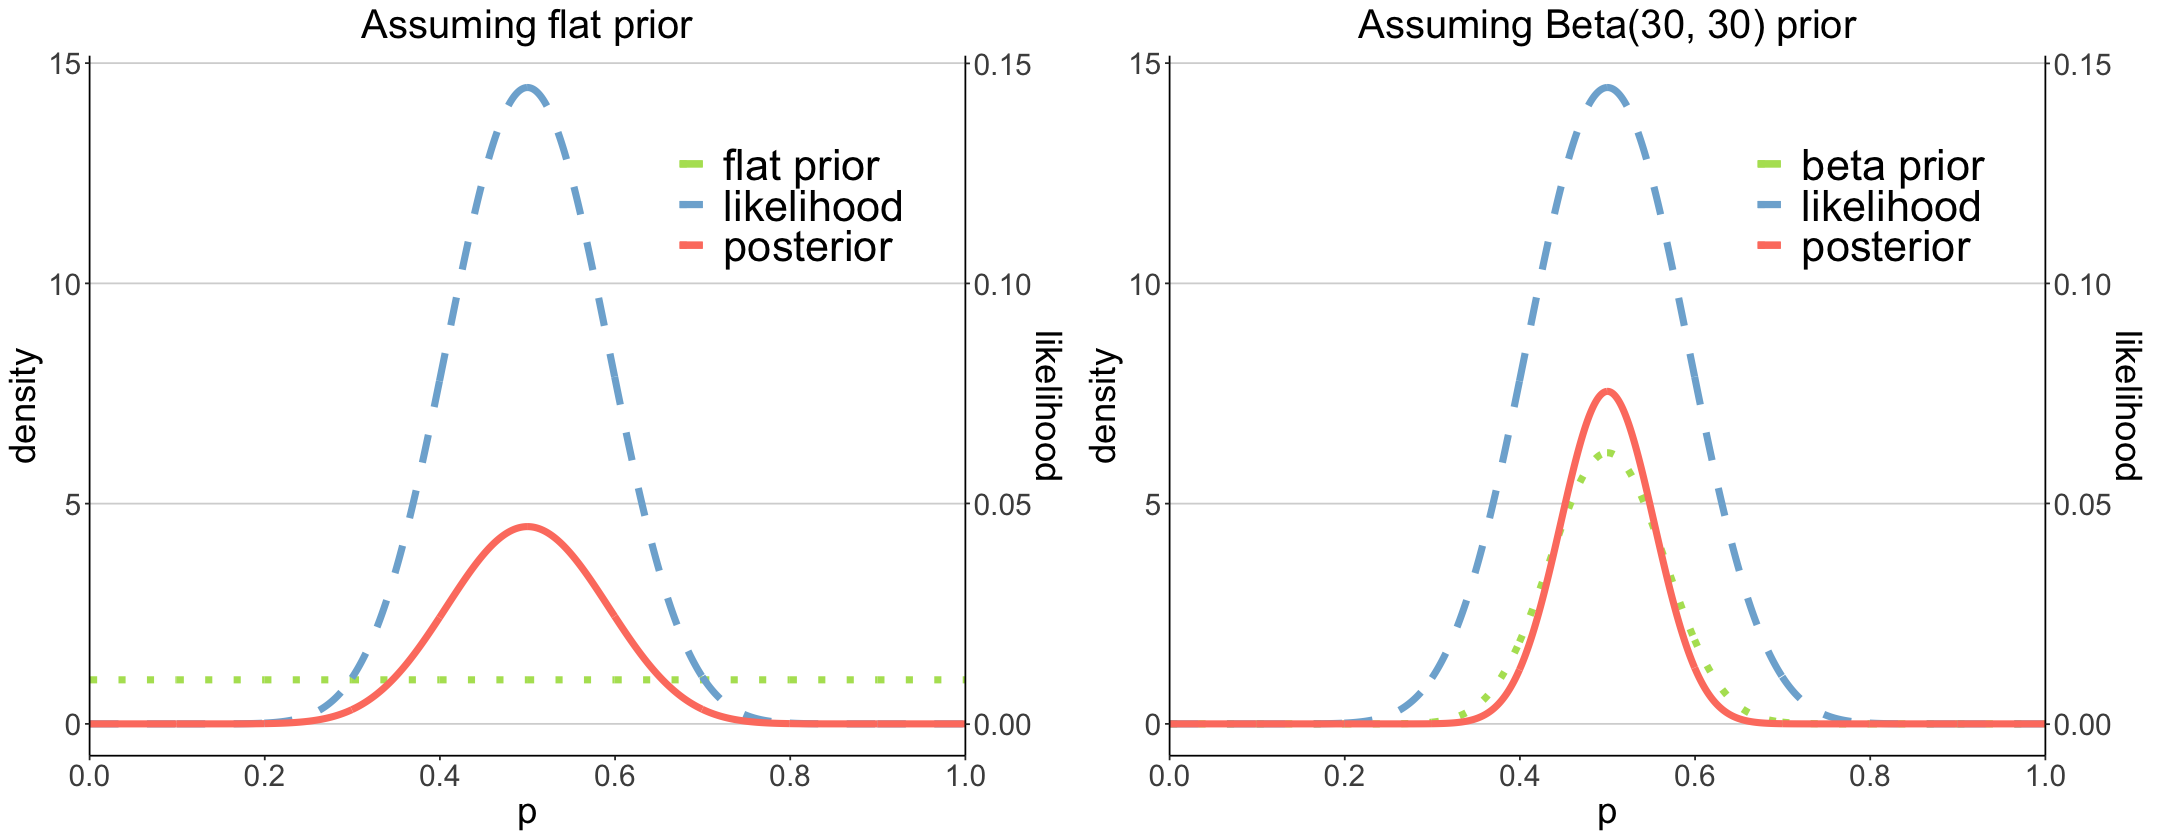

In [13]:
# the parameter we want to infer
n_grid <- 1000
p <- seq(from = 1 / (2 * n_grid), by = 1 / n_grid, length.out = n_grid)
# step
delta_p <- 1 / n_grid

# flat prior parameters
init_alpha_p_flat <- 1
init_beta_p_flat  <- 1

# beta prior parameters
init_alpha_p_beta <- 30
init_beta_p_beta  <- 30

# prior distributions
flat_prior <- dbeta(x = p, shape1 = init_alpha_p_flat, shape2 = init_beta_p_flat)
beta_prior <- dbeta(x = p, shape1 = init_alpha_p_beta, shape2 = init_beta_p_beta)

# likelihood distribution as a function of p
likelihood <- dbinom(x = k, size = n, prob = p)

# compute the final Beta parameters for the two posteriors
alpha_flat <- init_alpha_p_flat + k
beta_flat  <- init_beta_p_flat  + n - k
alpha_beta <- init_alpha_p_beta + k
beta_beta  <- init_beta_p_beta  + n - k

# posterior distributions
posterior_flat  <- dbeta(x = p, shape1 = alpha_flat, shape2 = beta_flat)
posterior_beta  <- dbeta(x = p, shape1 = alpha_beta, shape2 = beta_beta)

# PLOT - FLAT PRIOR
plt1 <- ggplot() +
geom_line(aes(x = p, y = flat_prior, color = "flat prior"), size = 2, linetype = "dotted") +
geom_line(aes(x = p, y = likelihood * 100, color = "likelihood"), size = 2, linetype = "dashed") +
geom_line(aes(x = p, y = posterior_flat, color = "posterior"), size = 2, linetype = "solid")  +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = "Assuming flat prior",
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 1)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[3], colors[2], colors[1]),
     breaks = c("flat prior", "likelihood", "posterior")
) + 
scale_y_continuous(sec.axis = sec_axis(~. / 100, name = "likelihood"))

# PLOT - BETA PRIOR
plt2 <- ggplot() +
geom_line(aes(x = p, y = beta_prior, color = "beta prior"), size = 2, linetype = "dotted") +
geom_line(aes(x = p, y = likelihood * 100, color = "likelihood"), size = 2, linetype = "dashed") +
geom_line(aes(x = p, y = posterior_beta, color = "posterior"), size = 2, linetype = "solid")  +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize + 4),
    legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = glue("Assuming Beta({init_alpha_p_beta}, {init_beta_p_beta}) prior"),
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 1)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
     name = "",
     values = c(colors[3], colors[2], colors[1]),
     breaks = c("beta prior", "likelihood", "posterior")
) + 
scale_y_continuous(sec.axis = sec_axis(~. / 100, name = "likelihood"))

plots <- list(plt1, plt2)
# figure adjustments
options(repr.plot.width = 18, repr.plot.height = 7)
plt <- ggarrange(plotlist = plots, nrow = 1, ncol = 2)
plt
options(repr.plot.width = std_width, repr.plot.height = std_height)

Mind the likelihood scale on the right of the two plots.

## B)

First, we define a function to easily compute the mean and another function for the most probable value.

In [14]:
# computes the mean of a Beta function
beta_mean <- function(a, b, k, n) {
    (a + k) / (a + b + n)
}

# computes the mode of a Beta function
beta_mode <- function(a, b, k, n) {
    (a + k - 1) / (a + b + n - 2)
}

Then we can compute the mode of the two posteriors. Of course we expect the two most probable values to be the same, and be equal to $p=0.5$, as data strongly suggests that.

In [15]:
all_mode_flat <- beta_mode(init_alpha_p_flat, init_beta_p_flat, k, n)
all_mode_beta <- beta_mode(init_alpha_p_beta, init_beta_p_beta, k, n)

cat(
    glue(
        "The most probable value for the coin probability is {round(all_mode_flat, 1)} (flat prior) and {round(all_mode_beta, 4)} (Beta({init_alpha_p_beta}, {init_beta_p_beta}) prior)"
    )
)

The most probable value for the coin probability is 0.5 (flat prior) and 0.5 (Beta(30, 30) prior)

Next we set a level of credibility for our credibility intervals, namely $95%$. Then, using the quantile function, it is quite straightforward to compute these intervals.

In [16]:
# level of credibility
cl <- 0.95

# left probability
q1 <- (1 - cl) / 2
# right probability
q2 <- 1 - q1

# compute left quantiles
all_p_min_flat <- qbeta(q1, alpha_flat, beta_flat)
all_p_min_beta <- qbeta(q1, alpha_beta, beta_beta)

# compute right quantiles
all_p_max_flat <- qbeta(q2, alpha_flat, beta_flat)
all_p_max_beta <- qbeta(q2, alpha_beta, beta_beta)

cat(
    glue(
        "The {cl*100}% credibility interval for p is ({round(all_p_min_flat, 4)}, {round(all_p_max_flat, 4)}) assuming a flat prior and ({round(all_p_min_beta, 4)}, {round(all_p_max_beta, 4)}) assuming a Beta({init_alpha_p_beta}, {init_beta_p_beta}) prior."
    )
)

The 95% credibility interval for p is (0.3306, 0.6694) assuming a flat prior and (0.3975, 0.6025) assuming a Beta(30, 30) prior.

We can now plot the two posteriors and show the credibility intervals we have just computed for a visual comparison.

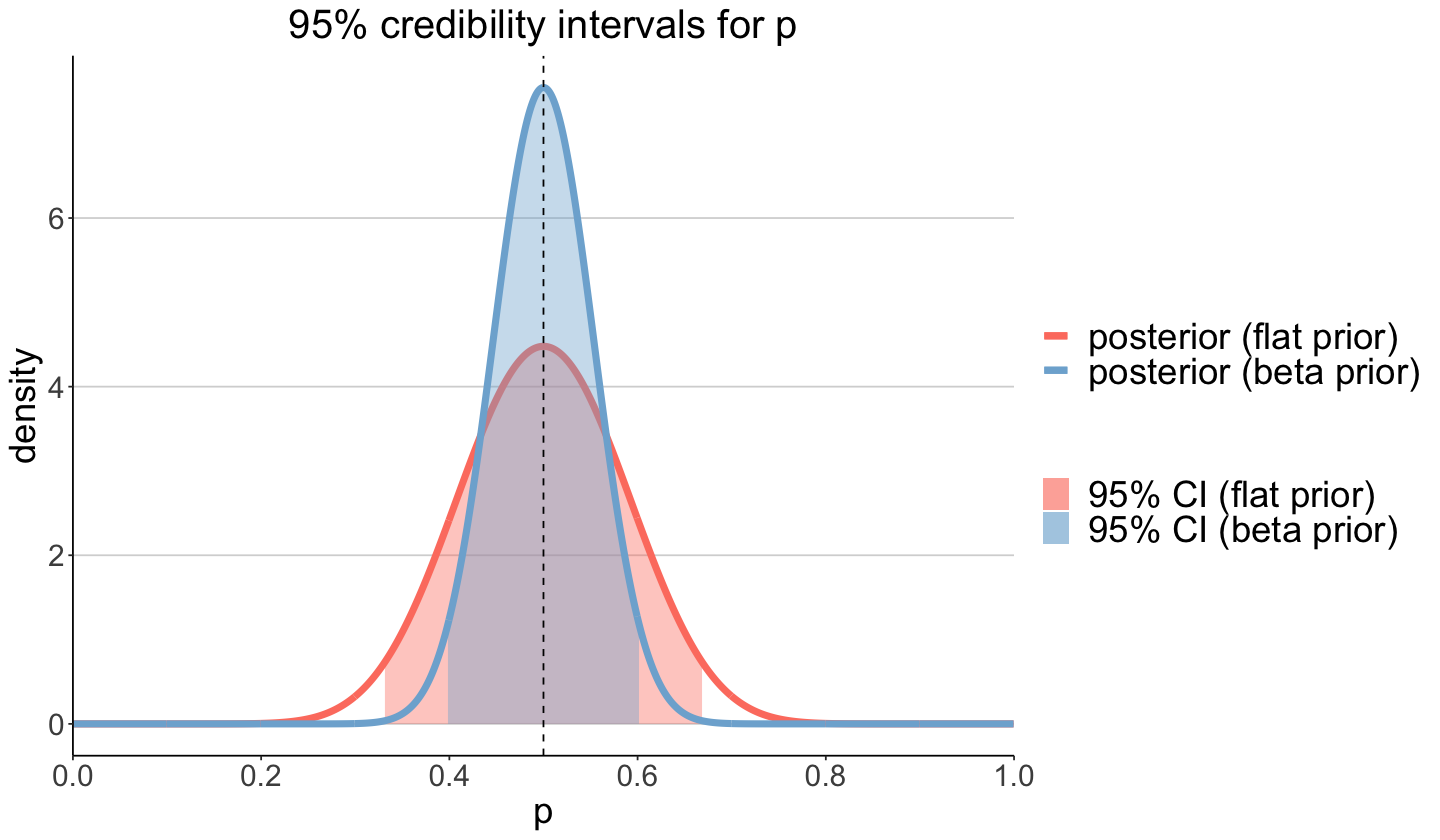

In [17]:
flat_df <- tibble(x = p, y = posterior_flat)
beta_df <- tibble(x = p, y = posterior_beta)

plt <- ggplot() +
geom_line(
    aes(
        x = p,
        y = posterior_flat,
        color = "posterior (flat prior)"
    ),
    size = 2,
    linetype = "solid"
) +
geom_area(
    data = flat_df[flat_df$x > all_p_min_flat & flat_df$x < all_p_max_flat, ],
    aes(
        x = x,
        y = y,
        fill = "95% CI (flat prior)"
    ),
    alpha = 0.4
) +
geom_area(
    data = beta_df[beta_df$x > all_p_min_beta & beta_df$x < all_p_max_beta, ],
    aes(
        x = x,
        y = y,
        fill = "95% CI (beta prior)"
    ),
    alpha = 0.4
) +
geom_line(
    aes(
        x = p,
        y = posterior_beta,
        color = "posterior (beta prior)"
    ),
    size = 2,
    linetype = "solid"
)  +
geom_vline(
    xintercept = all_mode_beta,
    size = 0.5,
    linetype = "dashed"
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = "95% credibility intervals for p",
    x     = "p",
    y     = "density",
) +
coord_cartesian(xlim = c(0, 1)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_fill_manual(
    name = "",
    values = c(colors[1], colors[2]),
    breaks = c("95% CI (flat prior)", "95% CI (beta prior)")
) +
scale_color_manual(
    name = "",
    values = c(colors[1], colors[2]),
    breaks = c("posterior (flat prior)", "posterior (beta prior)")
) +
guides(
    fill  = guide_legend(order = 2),
    color = guide_legend(order = 1)
)


plt

## C) Sequential analysis

The idea behind solving this point is to start with zero knowledge of data (i.e. no tosses) and only prior knowledge on the process at hand. Then, iterate through the tosses as they were done in real time, limiting our knowledge on "future" outcomes and allowing us to work only with "past" outcomes. To do that, we can update the prior distribution function at each iteration and set it to be exactly the posterior of the previous iteration!

In [18]:
# re-interpreting data
H      <- 1
T      <- 0
tosses <- c(T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H, H, H)

seq_tossess <- seq_len(length(tosses))

# initial parameters of the binomial distribution
k <- 0
n <- 0

# level of credibility
cl <- 0.95
# left probability
q1 <- (1 - cl) / 2
# right probability
q2 <- 1 - q1

# NO DATA YET:

# flat prior beta parameters
alpha_p_flat <- 1
beta_p_flat  <- 1
# flat prior - posterior quantiles
p_min_flat <- qbeta(q1, init_alpha_p_flat, init_beta_p_flat)
p_max_flat <- qbeta(q2, init_alpha_p_flat, init_beta_p_flat)
# flat prior - posterior most probable value
mode_flat  <- beta_mode(init_alpha_p_flat, init_beta_p_flat, k, n)

# beta prior beta parameters
alpha_p_beta <- 30
beta_p_beta  <- 30
# beta prior - posterior quantiles
p_min_beta <- qbeta(q1, init_alpha_p_beta, init_beta_p_beta)
p_max_beta <- qbeta(q2, init_alpha_p_beta, init_beta_p_beta)
# beta prior - posterior most probable value 
mode_beta  <- beta_mode(init_alpha_p_beta, init_beta_p_beta, k, n)

# ITERATION THROUGH DATA:
# for each outcome in data
for (event in tosses) {

    # update the binomial distribution parameters
    n <- 1
    k <- event

    # compute the new most probable value
    mode_flat <- c(mode_flat, beta_mode(alpha_p_flat, beta_p_flat, k, n))
    mode_beta <- c(mode_beta, beta_mode(alpha_p_beta, beta_p_beta, k, n))

    # compute the posterior parameters
    alpha_p_flat <- alpha_p_flat + k
    beta_p_flat  <- beta_p_flat + n - k
    alpha_p_beta <- alpha_p_beta + k
    beta_p_beta  <- beta_p_beta + n - k

    # compute the credibility intervals
    p_min_flat <- c(p_min_flat, qbeta(q1, alpha_p_flat, beta_p_flat))
    p_max_flat <- c(p_max_flat, qbeta(q2, alpha_p_flat, beta_p_flat))
    p_min_beta <- c(p_min_beta, qbeta(q1, alpha_p_beta, beta_p_beta))
    p_max_beta <- c(p_max_beta, qbeta(q2, alpha_p_beta, beta_p_beta))

}

Finally we can visualize how the most probable value and the credibility interval change as a function of the number of coin tosses. 

We thus plot the evolution of the most probable value for the two posteriors (flat and beta priors) and shade the credibility interval around the trend line.

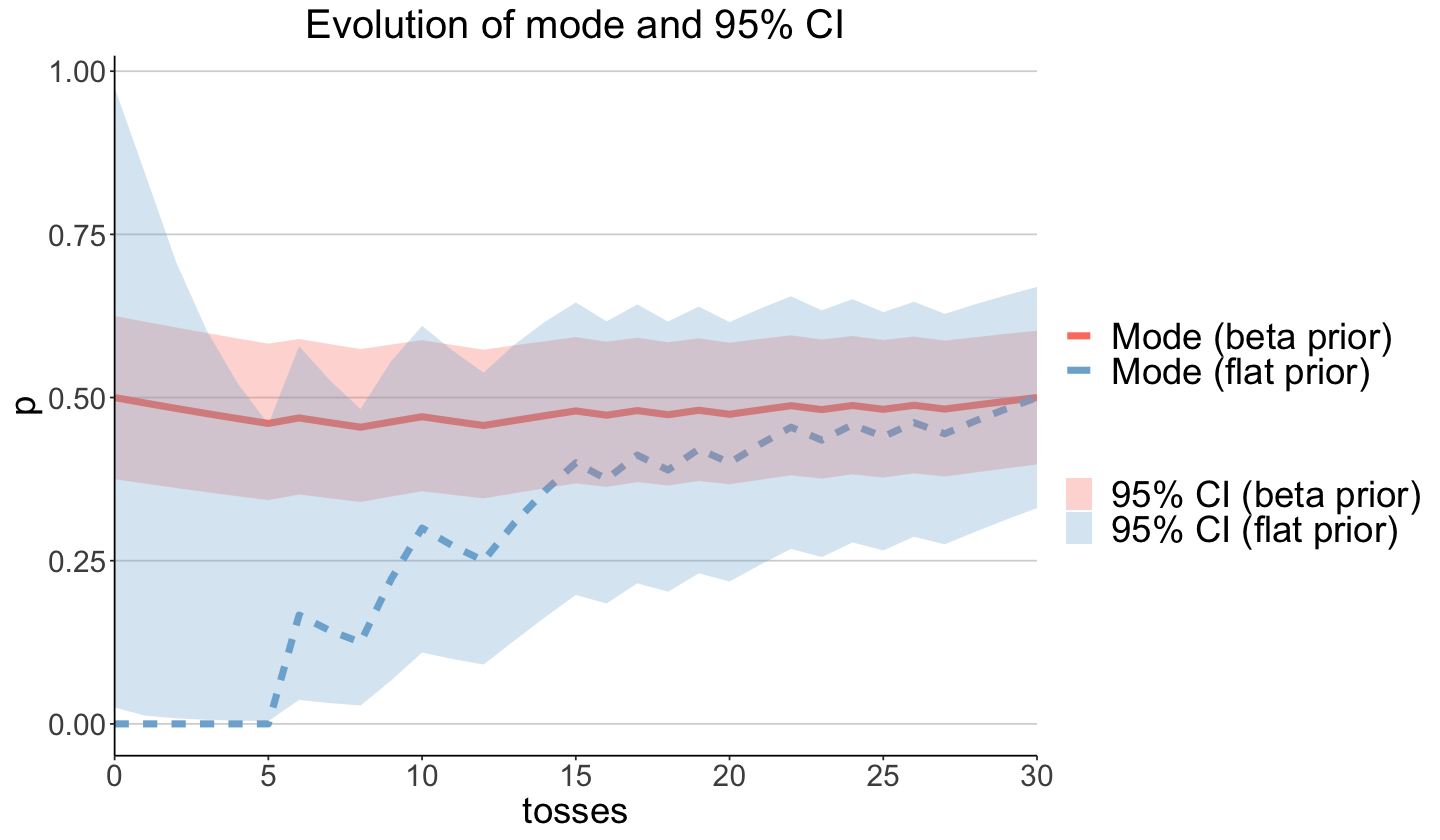

In [19]:
n <- n_H + n_T

df <- tibble(
    x = rep(0:n, 2),
    y = c(mode_flat, mode_beta),
    y_max = c(p_max_flat, p_max_beta),
    y_min = c(p_min_flat, p_min_beta),
    label = c(rep("flat", n + 1), rep("beta", n + 1))
)

df[is.na(df)] <- 0

plt <- ggplot(
    data = df
) +
geom_line(
    aes(
        x = x,
        y = y,
        linetype = label,
        color    = label,
    ),
    size = 2
) +
geom_ribbon(
    aes(
        x = x,
        y = y,
        ymin = y_min,
        ymax = y_max,
        fill = label
    ),
    alpha = 0.3
) +
theme_classic() +
theme(
    plot.title   = element_text(size = fontsize + 2, hjust = 0.5),
    axis.title   = element_text(size = fontsize),
    axis.text    = element_text(size = fontsize - 4),
    legend.title = element_text(size = fontsize),
    legend.text  = element_text(size = fontsize),
    # legend.position = c(0.8, 0.825),
    panel.grid.major.y = element_line(
    color    = alpha("black", 0.2),
    size     = 0.5,
    linetype = 1
)
) +
labs(
    title = "Evolution of mode and 95% CI",
    x     = "tosses",
    y     = "p",
) +
coord_cartesian(xlim = c(0, 30)) +
scale_x_continuous(breaks = pretty_breaks(), expand = c(0, 0)) +
scale_color_manual(
    name = "",
    values = c(colors[1], colors[2]),
    labels = c("Mode (beta prior)", "Mode (flat prior)"),
    breaks = c("beta", "flat")
) +
scale_fill_manual(
    name = "",
    values = c(colors[1], colors[2]),
    labels = c("95% CI (beta prior)", "95% CI (flat prior)"),
    breaks = c("beta", "flat")
) +
guides(
    fill  = guide_legend(order = 2),
    color = guide_legend(order = 1),
    linetype = "none"
)
plt

## D)

First we need to extract the final results of our sequential analysis, that are the last elements of the vectors we have created.

In [20]:
final_p_min_flat <- tail(p_min_flat, n = 1)
final_p_max_flat <- tail(p_max_flat, n = 1)
final_p_min_beta <- tail(p_min_beta, n = 1)
final_p_max_beta <- tail(p_max_beta, n = 1)
final_mode_flat  <- tail(mode_flat, n = 1)
final_mode_beta  <- tail(mode_beta, n = 1)

And then we print the results we obtained when considering all data as a whole and those obtained in the final step of the sequential analysis.

In [21]:
cat("CONSIDERING ALL DATA AS A WHOLE\n\n")
cat("Flat prior:\n")
cat(glue(" Mode \t= {round(all_mode_flat, 4)}"), "\n")
cat(glue(" 95% CI = ({round(all_p_min_flat, 4)}, {round(all_p_max_flat, 4)})"), "\n\n")

cat(glue("Beta({init_alpha_p_beta}, {init_alpha_p_beta}) prior:"), "\n")
cat(glue(" Mode \t= {round(all_mode_beta, 4)}"), "\n")
cat(glue(" 95% CI = ({round(all_p_min_beta, 4)}, {round(all_p_max_beta, 4)})"), "\n\n")

cat("SEQUENTIAL ANALYSIS FINAL RESULTS\n\n")
cat("Flat prior:\n")
cat(glue(" Mode \t= {round(final_mode_flat, 4)}"), "\n")
cat(glue(" 95% CI = ({round(final_p_min_flat, 4)}, {round(final_p_max_flat, 4)})"), "\n\n")

cat(glue("Beta({init_alpha_p_beta}, {init_alpha_p_beta}) prior:"), "\n")
cat(glue(" Mode \t= {round(final_mode_beta, 4)}"), "\n")
cat(glue(" 95% CI = ({round(final_p_min_beta, 4)}, {round(final_p_max_beta, 4)})"), "\n\n")

CONSIDERING ALL DATA AS A WHOLE

Flat prior:
 Mode 	= 0.5 
 95% CI = (0.3306, 0.6694) 

Beta(30, 30) prior: 
 Mode 	= 0.5 
 95% CI = (0.3975, 0.6025) 

SEQUENTIAL ANALYSIS FINAL RESULTS

Flat prior:
 Mode 	= 0.5 
 95% CI = (0.3306, 0.6694) 

Beta(30, 30) prior: 
 Mode 	= 0.5 
 95% CI = (0.3975, 0.6025) 



As we can see, results are *exactly* the same!